<table style="background-color:#FFFFFF">   
  <tr>     
  <td><img src="https://upload.wikimedia.org/wikipedia/commons/9/95/Logo_EPFL_2019.svg" width="150x"/>
  </td>     
  <td>
  <h1> <b>CS-461: Foundation Models and Generative AI</b> </h1>
  Prof. Charlotte Bunne  
  </td>   
  </tr>
</table>

# 📚 Graded Assignment 1  
### CS-461: Foundation Models and Generative AI - Fall 2025  - Due: October 8, 23:59 CET

Welcome to the first graded assignment!
In this assignment, you will **implement and explore self-supervised learning** on a downsampled subset of the [ImageNet-1k dataset](https://www.image-net.org/), and evaluate how well your model generalizes **both in-distribution and out-of-distribution (OOD)**.  

---

## 🎯 Learning Objectives
By completing this assignment, you will learn to:
- Implement a custom **encoder** and **projection head** for images  
- Experiment with **data augmentations** for self-supervised learning  
- Train a model using a **self-supervised loss**  
- Evaluate learned representations with **k-NN** and **linear probes**  
- Assess **out-of-distribution (OOD) generalization** to unseen classes  
- Save, visualize, and submit results in a reproducible way  

---

## ⚡ Practical Notes
- **Dataset:**  
  - Training: 200 ImageNet classes, 500 images each (100k total)  
  - Validation: 200 ImageNet classes, 50 images each (10k total)  
  - **OOD dataset:** 200 unseen classes, 50 images each (10k total)  
- Use OOD only for **evaluation**, never for training.  
- Checkpoints and evaluation intervals are already set up — your main tasks are to fill in missing functions and customize the model.  
- Some helper utilities (e.g., dataset loaders, probes) are provided in `utils.py`.  

---

👉 **Deliverables:** You will submit:
- Your modified **`models.py`**  
- Trained weights in **`final_model.safetensors`**  
- A short **report.md** (max 500 words) — including **discussion of OOD results**  
- This completed notebook **CS461_Assignment1.ipynb**  

---

⚠️ **Important:** Don’t forget to fill in your **SCIPER number** and **full name** in Section 0, otherwise you will receive **0 points**.  

First, we import packages and set up the device. \
Feel free to add any additional packages you may need.

In [1]:
# Automatically reloads modules when you make changes (useful during development)
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import shutil

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import DataLoader
from safetensors.torch import save_model

import copy

import time

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 🆔 0. SCIPER Number and Name  

⚠️ **IMPORTANT!** ⚠️  
You **must** fill in your **SCIPER number** and **full name** below.  

This is **required for automatic grading**.  
If you do **not** provide this information, you will receive **0️⃣ (zero)** for this assignment. 

In [3]:
SCIPER = 326893
LAST_NAME = 'Belissent'
FIRST_NAME = 'Guillaume'  

## 1. Datasets & Utilities

- In the following, we will work with a subset of the ImageNet-1k dataset: color images downsampled to 64×64, covering 200 classes.
- The training set contains 500 images per class (100,000 images in total), and the validation set contains 50 images per class (10,000 images in total).
- The Out-Of-Distribution (OOD) datasets contain images from classes not present in the training set. It contains 50 images from 200 different classes (1,000 images in total).
- The purpose of these OOD datasets is to evaluate the generalization capabilities of the learned representations. You should not use it for training.
- During evalution, we will measure your model's performance on another OOD dataset (different from the one provided here), so make sure to not overfit on the provided OOD dataset.

<!-- Let's download/load it and define a default transformation turning a PIL Image into a `torch.tensor` -->
Make sure that you have access to the `/shared/CS461/cs461_assignment1_data/` folder. The folder structure should look like this:
```
cs461_assignment1_data/
└── train.npz
└── val.npz
└── ood.npz
```


Import dataset class and other utilities you developed in previous homeworks:

In [4]:
from utils import ImageDatasetNPZ, default_transform, seed_all
from utils import run_knn_probe, run_linear_probe, extract_features_and_labels
from utils import BYOLTransform, byol_collate_fn
from utils import get_class_name

hwloc/linux: failed to find sysfs cpu topology directory, aborting linux discovery.
Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


For reproducibility, you can use the provided `seed_all` function to set the random seed for all relevant libraries (Python, NumPy, PyTorch).

In [5]:
seed_all(42)  # For reproducibility, you can use any integer here

You probably want to implement custom data augmentations for the self-supervised learning method you choose. \
Feel free to swap the `default_transform` defined below and create multiple instances of datasets with different transforms.

In [6]:
data_dir = Path('/shared/CS461/cs461_assignment1_data/')

In [7]:
byol_transform = BYOLTransform(size=64)
default_transform = default_transform()

train_dataset = ImageDatasetNPZ(data_dir / 'train.npz', transform=byol_transform)
val_dataset = ImageDatasetNPZ(data_dir / 'val.npz', transform=default_transform)

You can split the provided OOD dataset into a training and validation set using the code below. \
You should not use the training split for actually training your models, but only for evaluation (e.g. kNN or linear probing).

In [8]:
rng = np.random.RandomState(42)
ds_ood = ImageDatasetNPZ(data_dir / 'ood.npz', transform=None)
ood_val_ratio = 0.2
train_mask = rng.permutation(len(ds_ood)) >= int(len(ds_ood) * ood_val_ratio)
ds_oods_train = torch.utils.data.Subset(ds_ood, np.where(train_mask)[0])
ds_oods_val = torch.utils.data.Subset(ds_ood, np.where(~train_mask)[0])

In [9]:
batch_size = 256
num_workers = 4
pin_memory = True
collate_fn = byol_collate_fn

In [10]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=True, collate_fn=collate_fn)
val_loader  = DataLoader(val_dataset,  batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=False, collate_fn=None)

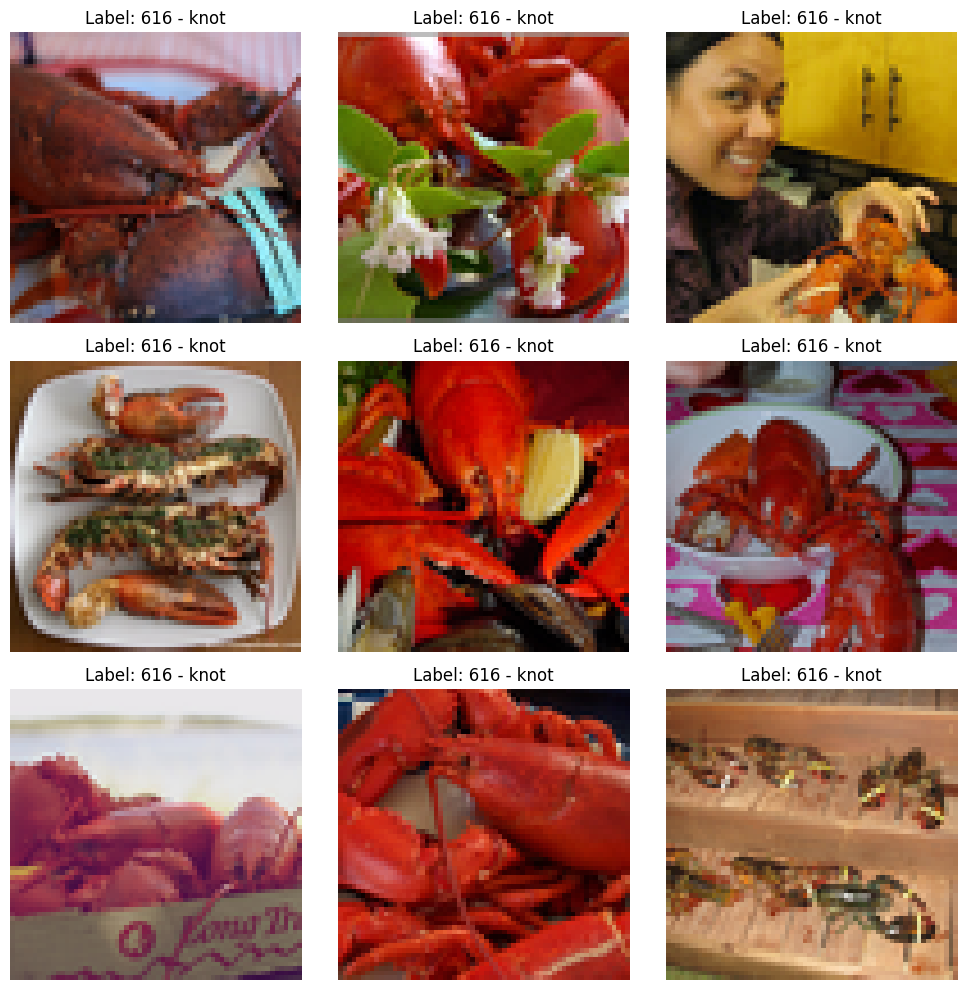

In [11]:
num_images = 9
grid_size = int(np.sqrt(num_images))

fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

for idx in range(num_images):
    # Get individual image and label from the dataset
    img, label = val_dataset[idx]

    # Convert to numpy if it's a torch tensor
    if isinstance(img, torch.Tensor):
        img = img.cpu().numpy()
        if img.ndim == 3:  # CxHxW -> HxWxC
            img = img.transpose(1, 2, 0)

    i = idx // grid_size
    j = idx % grid_size
    axes[i, j].imshow(img)
    axes[i, j].axis('off')
    axes[i, j].set_title(f'Label: {label} - {get_class_name(label)}')

plt.tight_layout()
plt.show()

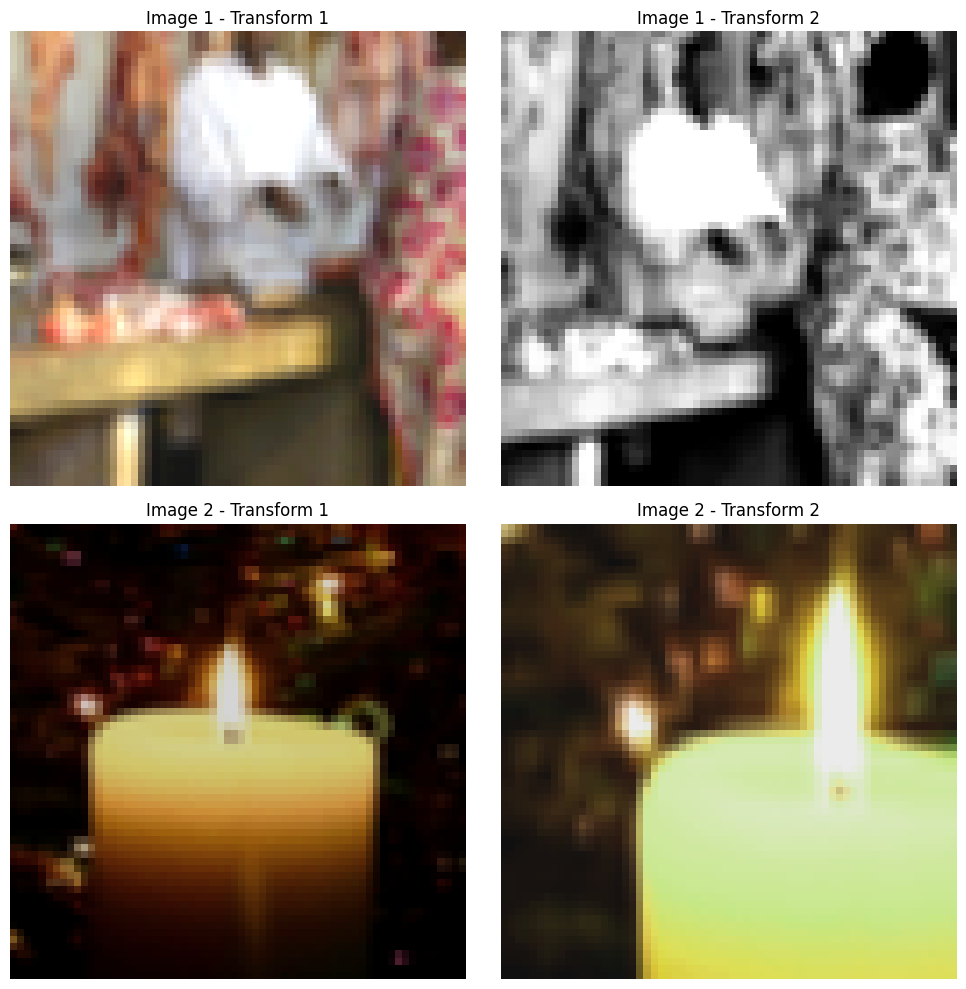

In [12]:
x1, x2, y = next(iter(train_loader))
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

def tensor_to_img(x):
    return x.permute(1, 2, 0).cpu().numpy()

# Plot first pair (first image)
axes[0, 0].imshow(tensor_to_img(x1[0]))
axes[0, 0].axis('off')
axes[0, 0].set_title('Image 1 - Transform 1')

axes[0, 1].imshow(tensor_to_img(x2[0]))
axes[0, 1].axis('off')
axes[0, 1].set_title('Image 1 - Transform 2')

# Plot second pair (second image)
axes[1, 0].imshow(tensor_to_img(x1[1]))
axes[1, 0].axis('off')
axes[1, 0].set_title('Image 2 - Transform 1')

axes[1, 1].imshow(tensor_to_img(x2[1]))
axes[1, 1].axis('off')
axes[1, 1].set_title('Image 2 - Transform 2')

plt.tight_layout()
plt.show()

# 2. Load Your Model

- Load your model from `models.py`.
- You will need to modify the `encoder` and `projection` modules, as the provided template implementation is only a placeholder.
- You SHOULD NOT change the `input_dim`, `input_channels`, and `feature_dim` parameters of the `ImageEncoder` class.
- You can use an existing architecture (e.g., ResNet, ViT) but you SHOULD NOT use any pre-trained weights.

In [13]:
%autoreload
from models import ImageEncoder
from utils import EMA

online_network = ImageEncoder().to(device)
target_network = ImageEncoder().to(device)

target_network.load_state_dict(copy.deepcopy(online_network.state_dict()))
for param in target_network.parameters():
    param.requires_grad = False

## 3. Helpers for Training & Evaluation

We suggest you to implement the following helper functions to keep your training and evaluation loops clean and organized. \
- `training_step`: Performs a single training step (forward pass, loss computation, backward pass, optimizer step) and returns the loss value.
- `evaluation_step`: Evaluates the model on the validation dataset and returns the accuracy.

Depending on your specific requirements, you may also want to implement additional utility functions for tasks such as data loading, metric computation, and logging.

As you have seen from previous assignments, loss functions for self-supervised learning objectives can be quite complex. \
Feel free to implement any helper functions you may need to compute the loss.


In [14]:
def training_step(online_network, target_network, train_loader, optimizer, ema):
    losses = []
    for x1, x2, y in tqdm(train_loader):
        
        x1, x2 = x1.to(device), x2.to(device)
        
        # _, _, pred_online = online_network(x1)

        # with torch.no_grad():
        #     _, proj_target, _ = target_network(x2)
        
        # byol_loss = custom_loss_function(pred_online,proj_target)


        # SYMETRIC LOSS CALCULATION
        with torch.amp.autocast(device):
            _, _, pred1 = online_network(x1)
            with torch.no_grad():
                _, proj2, _ = target_network(x2)
            
            _, _, pred2 = online_network(x2)
            with torch.no_grad():
                _, proj1, _ = target_network(x1)
                
            # normalized in forward
            # pred1 = F.normalize(pred1, dim=-1, eps=1e-8)
            # proj2 = F.normalize(proj2, dim=-1, eps=1e-8)
            # pred2 = F.normalize(pred2, dim=-1, eps=1e-8)
            # proj1 = F.normalize(proj1, dim=-1, eps=1e-8)
            
            loss1 = 2 - 2 * (pred1 * proj2.detach()).sum(dim=-1).mean()
            loss2 = 2 - 2 * (pred2 * proj1.detach()).sum(dim=-1).mean()
            byol_loss = (loss1 + loss2) / 2
    
            
            optimizer.zero_grad()
            byol_loss.backward()
            optimizer.step()
            
            ema.update(online_network, target_network)

        losses.append(byol_loss.item())
    # plt.plot(losses)
    # plt.show()
    return {'loss': np.mean(losses)}

In [ ]:
from eval import evaluate_model

def evaluation_step(online_network, train_loader, val_loader):
    train_features, train_labels = extract_features_and_labels(online_network, train_loader, normalize=True)
    test_features, test_labels = extract_features_and_labels(online_network, val_loader, normalize=True)
    acc = run_knn_probe(train_features, train_labels, test_features, test_labels)
    # knn_acc, probe_acc = evaluate_model(online_network, val_loader, val_loader)
    # return {'knn_accuracy': knn_acc, 'probe_accuracy': probe_acc}
    return {'knn_accuracy': acc}

In [16]:
def custom_loss_function(pred_online,proj_target):
    loss = 2 - 2 * (pred_online*proj_target.detach()).sum(dim=-1).mean()
    return loss

# 4. Optimizer Configuration

In [17]:
# Feel free to adapt and add more arguments
lr = 1e-4
weight_decay = 1e-4
lr_step_size = 10
lr_gamma = 0.1

In [18]:
optimizer = torch.optim.Adam(online_network.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_step_size, gamma=lr_gamma)

# 5. Training Loop

Adapt your training configuration and implement the training loop. \
You probably want to save model checkpoints and evaluate the model on the validation set at regular intervals.

In [19]:
n_epochs = 100  # Adjust the number of epochs as needed
eval_interval = 2 # Evaluate the model every 'eval_interval' epochs
save_interval = 10  # Save the model every 'save_interval' epochs

checkpoints_dir = Path('/home/cs461/cs461_assignment1/checkpoints/')
if not checkpoints_dir.exists():
    checkpoints_dir.mkdir(parents=True, exist_ok=False)
    
logs_dir = Path(f'/home/cs461/cs461_assignment1/logs/')
logs_dir.mkdir(exist_ok=True)

log_file = Path(f'/home/cs461/cs461_assignment1/logs/logs_{int(time.time())}')
log_f = open(log_file, "a")
log_f.write(f'Training logs: \noptimizer = {optimizer}, step size = {lr_step_size}, gamma = {lr_gamma}, nepochs = {n_epochs}')

import csv
csv_path = Path("training_logs.csv")
f = open(csv_path, mode='w', newline='')
writer = None

In [ ]:
from utils import check_representation_collapse, check_projector_output, extract_features_and_labels, visualize_features, embedding_metrics
%autoreload


for epoch in range(n_epochs):
    # TODO: Implement the training and evaluation loop
    ema_schedule = lambda epoch: 0.995*(epoch/n_epochs) + 0.999*(1 - epoch/n_epochs)
    ema = EMA(beta=ema_schedule(epoch))
    
    online_network.train()
    train_stats = training_step(online_network, target_network, train_loader, optimizer, ema)

    lr_scheduler.step()

    if (epoch + 1) % eval_interval == 0:
        online_network.eval()
        epoch_data = {'epoch': epoch + 1}
        val_stats = evaluation_step(online_network, train_loader, val_loader)
        # print(f"Epoch {epoch+1}/{n_epochs} Train Loss: {train_stats['loss']:.4f}, Val kNN-5 Accuracy: {val_stats['knn_accuracy']:.2f}%, Probe Accuracy: {val_stats['probe_accuracy']:.2f}%")
        # logging.write(f"\nEpoch {epoch+1}/{n_epochs} Train Loss: {train_stats['loss']:.4f}, Val kNN-5 Accuracy: {val_stats['knn_accuracy']:.2f}%, Probe Accuracy: {val_stats['probe_accuracy']:.2f}%")
        print(f"Epoch {epoch+1}/{n_epochs} Train Loss: {train_stats['loss']:.4f}, Val kNN-5 Accuracy: {val_stats['knn_accuracy']*100:.2f}%")
        log_f.write(f"\nEpoch {epoch+1}/{n_epochs} Train Loss: {train_stats['loss']:.4f}, Val kNN-5 Accuracy: {val_stats['knn_accuracy']*100:.2f}%")
        log_f.flush()
        emb_metrics = embedding_metrics(online_network, train_loader)
        print(f"Mean similarity: {emb_metrics['mean_sim']:.4f}, Positive pair mean similarity: {emb_metrics['mean_pos_sim']:.4f}, Embedding variance: {emb_metrics['embedding_var']}")
        
        epoch_data.update(emb_metrics)
        epoch_data.update(val_stats)
        epoch_data.update(train_stats)
        
        if writer is None:
            fieldnames = list(epoch_data.keys())
            writer = csv.DictWriter(f, fieldnames=fieldnames)
            writer.writeheader()
        writer.writerow(epoch_data)
        f.flush()

    if (epoch + 1) % save_interval == 0:
        checkpoint_path = checkpoints_dir / f'model_epoch_{epoch+1}.safetensors'
        save_model(online_network, checkpoint_path)
        print(f"Model checkpoint saved at {checkpoint_path}")


# Save the final model
final_model_path = checkpoints_dir / 'model_final.safetensors'
save_model(online_network, final_model_path)

100%|██████████| 391/391 [03:13<00:00,  2.02it/s]


Epoch 2/100 Train Loss: 0.5391, Val kNN-5 Accuracy: 24.34%
Mean similarity: 0.5561, Positive pair mean similarity: 0.8861, Embedding variance: 0.32367199659347534


100%|██████████| 391/391 [03:13<00:00,  2.02it/s]


Epoch 4/100 Train Loss: 0.4530, Val kNN-5 Accuracy: 24.56%
Mean similarity: 0.5126, Positive pair mean similarity: 0.8859, Embedding variance: 0.2127917781472206


100%|██████████| 391/391 [03:13<00:00,  2.02it/s]


Epoch 6/100 Train Loss: 0.3926, Val kNN-5 Accuracy: 26.33%
Mean similarity: 0.5123, Positive pair mean similarity: 0.8963, Embedding variance: 0.14153750985860825


100%|██████████| 391/391 [03:14<00:00,  2.01it/s]


Epoch 8/100 Train Loss: 0.3521, Val kNN-5 Accuracy: 26.69%
Mean similarity: 0.5070, Positive pair mean similarity: 0.9009, Embedding variance: 0.08873803913593292


100%|██████████| 391/391 [03:13<00:00,  2.02it/s]


Epoch 10/100 Train Loss: 0.3322, Val kNN-5 Accuracy: 27.06%
Mean similarity: 0.5120, Positive pair mean similarity: 0.9019, Embedding variance: 0.061306463554501534
Model checkpoint saved at /home/cs461/cs461_assignment1/checkpoints/model_epoch_10.safetensors


100%|██████████| 391/391 [03:14<00:00,  2.02it/s]


Epoch 12/100 Train Loss: 0.3214, Val kNN-5 Accuracy: 27.99%
Mean similarity: 0.5148, Positive pair mean similarity: 0.9067, Embedding variance: 0.05381740443408489


100%|██████████| 391/391 [03:14<00:00,  2.01it/s]


Epoch 14/100 Train Loss: 0.3251, Val kNN-5 Accuracy: 27.67%
Mean similarity: 0.5276, Positive pair mean similarity: 0.9015, Embedding variance: 0.04647696577012539


100%|██████████| 391/391 [03:13<00:00,  2.02it/s]


Epoch 16/100 Train Loss: 0.3304, Val kNN-5 Accuracy: 28.27%
Mean similarity: 0.5247, Positive pair mean similarity: 0.9010, Embedding variance: 0.04466278664767742


100%|██████████| 391/391 [03:13<00:00,  2.02it/s]


Epoch 18/100 Train Loss: 0.3333, Val kNN-5 Accuracy: 28.89%
Mean similarity: 0.5297, Positive pair mean similarity: 0.8962, Embedding variance: 0.0415129903703928


100%|██████████| 391/391 [03:14<00:00,  2.01it/s]


Epoch 20/100 Train Loss: 0.3325, Val kNN-5 Accuracy: 29.05%
Mean similarity: 0.5226, Positive pair mean similarity: 0.9015, Embedding variance: 0.04103459417819977
Model checkpoint saved at /home/cs461/cs461_assignment1/checkpoints/model_epoch_20.safetensors


100%|██████████| 391/391 [03:14<00:00,  2.01it/s]


Epoch 22/100 Train Loss: 0.3284, Val kNN-5 Accuracy: 29.05%
Mean similarity: 0.5193, Positive pair mean similarity: 0.9032, Embedding variance: 0.04124102555215359


100%|██████████| 391/391 [03:14<00:00,  2.01it/s]


Epoch 24/100 Train Loss: 0.3283, Val kNN-5 Accuracy: 28.89%
Mean similarity: 0.5324, Positive pair mean similarity: 0.9029, Embedding variance: 0.03948748856782913


100%|██████████| 391/391 [03:14<00:00,  2.01it/s]


Epoch 28/100 Train Loss: 0.3273, Val kNN-5 Accuracy: 28.90%
Mean similarity: 0.5246, Positive pair mean similarity: 0.9032, Embedding variance: 0.040426213294267654


100%|██████████| 391/391 [03:14<00:00,  2.01it/s]


Epoch 30/100 Train Loss: 0.3266, Val kNN-5 Accuracy: 29.03%
Mean similarity: 0.5274, Positive pair mean similarity: 0.9007, Embedding variance: 0.039447858929634094
Model checkpoint saved at /home/cs461/cs461_assignment1/checkpoints/model_epoch_30.safetensors


100%|██████████| 391/391 [03:14<00:00,  2.01it/s]


Epoch 32/100 Train Loss: 0.3271, Val kNN-5 Accuracy: 28.83%
Mean similarity: 0.5193, Positive pair mean similarity: 0.9026, Embedding variance: 0.03934537433087826


 70%|███████   | 275/391 [02:17<00:57,  2.02it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

 52%|█████▏    | 205/391 [01:42<01:31,  2.02it/s]

In [ ]:
from utils import check_representation_collapse, check_projector_output, extract_features_and_labels, visualize_features, similarity_testing
%autoreload
similarity_testing(online_network, train_loader)

In [ ]:
from utils import check_representation_collapse, check_projector_output, extract_features_and_labels

features, std_feature = check_representation_collapse(online_network, val_loader)
# check_projector_output(online_network, val_loader)
train_features, train_labels = extract_features_and_labels(online_network, val_loader, normalize=False)
visualize_features(train_features, train_labels, n_classes=20)

# 6. Visualize Results

To better understand the performance of your trained model, visualize some results. \
You can visualize:
- Sample images from the validation set along with their predicted labels.
- Training and validation loss curves over epochs.

In [ ]:
# TODO: Visualize some results from your trained model.

# 7. Submission Instructions

You must submit the following files:
- `models.py`: Contains the implementation of your model architecture.
- `final_model.safetensors`: The trained model weights saved in the safetensors format.
- `report.md`: A brief report summarizing your approach, design choices, and results.
- `CS461_Assignment1.ipynb`: The Jupyter notebook containing your code and explanations. Make sure to save your progress before running the cell below.

You will submit your assignment under a single folder named `/home/cs461_assignment1_submission` containing the above files. \
Make sure to replace `<SCIPER>`, `<LAST_NAME>`, and `<FIRST_NAME>` with your actual SCIPER number, last name, and first name respectively. \
The following cell will help you move the files into the submission folder.

In [ ]:
work_dir = Path('.')
output_dir = Path.home() / 'cs461_assignment1_submission'

if not output_dir.exists():
    output_dir.mkdir(parents=True, exist_ok=False)
    
shutil.copy(final_model_path, output_dir / 'final_model.safetensors')
shutil.copy(work_dir / 'models.py', output_dir / 'models.py')
shutil.copy(work_dir / 'CS461_Assignment1.ipynb', output_dir / 'CS461_Assignment1.ipynb')
shutil.copy(work_dir / 'report.md', output_dir / 'report.md')

Check that all required files are present in the submission folder before running the cell below.

In [ ]:
assert SCIPER is not None and LAST_NAME is not None and FIRST_NAME is not None, "Please set your SCIPER, LAST_NAME, and FIRST_NAME variables."

list_of_files = ['final_model.safetensors', 'models.py', 'CS461_Assignment1.ipynb', 'report.md']
files_found = all((output_dir / f).exists() for f in list_of_files)
assert files_found, f"One or more required files are missing in the submission folder: {list_of_files}"


You can test whether your submission folder is appropriately structured by using the `eval.py`:
```bash
python eval.py
```

In [ ]:
### Uncomment the line below to run the evaluation script and check your model's performance

# !python eval.py

---
🎉 **Congratulations!**  
You’ve completed Assignment 1. Good luck, and don’t forget to double-check your submission!